<a href="https://colab.research.google.com/github/GiX007/agent-labs/blob/main/04_langGraph/01_components.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangGraph Components

## Setup

In [ ]:
from dotenv import load_dotenv, find_dotenv
dotenv_path = find_dotenv() or '/content/OPENAI_API_KEY.env'
load_dotenv(dotenv_path)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !pip install langgraph langchain langchain-openai langchain-community tavily-python

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

## Agent

In [ ]:
# Initialize Tavily search tool with a maximum of 4 results
tool = TavilySearchResults(max_results=4) # increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> For python typing annotations, see [python documents](https://docs.python.org/3/library/typing.html).

In [ ]:
# Define the structure of the agent's state, specifying that messages is a list
class AgentState(TypedDict):
  messages: Annotated[list[AnyMessage], operator.add]

We create the ```AgentState``` class (```TypedDict```) to define the structure of an agent's state clearly. It stores the ```messages``` list as input, keeps track of the conversation, and lets us safely pass or update the agent's state while ensuring the output is always a properly formatted message history (```operator.add```).

Overview of the Agent we will create:

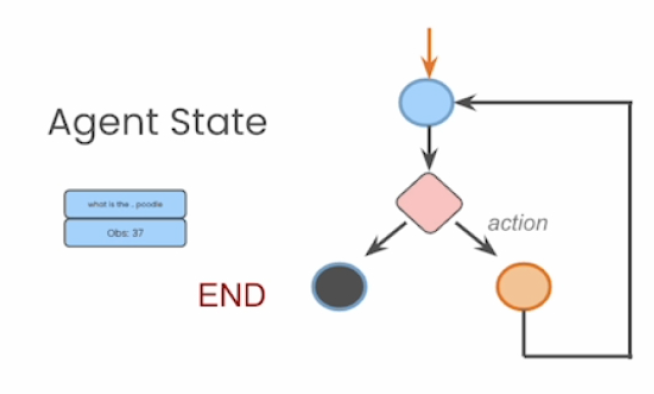

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [ ]:
class Agent:
  """
  An agent that loops between reasoning (LLM) and taking actions (tools).

  It manages conversation state, decides when to run tools, executes them, and feeds observations back to the model automatically.
  """

  def __init__(self, model, tools, system=""):
    # Create and set up the agent's workflow graph (LLM -> actions -> back to LLM)
    self.system = system

    graph = StateGraph(AgentState) # create a state graph to manage the agent's workflow
    graph.add_node("llm", self.call_openai) # add LLM node: where the model generates messages
    graph.add_node("action", self.take_action) # add action node: where tools are executed
    graph.add_conditional_edges( # add conditional edges: go to action if there are tool calls, else end
        "llm",
        self.exists_action,
        {True: "action", False: END}
      )
    graph.add_edge("action", "llm") # after performing action, return to LLM
    graph.set_entry_point("llm") # set entry point of the workflow
    self.graph = graph.compile() # compile the graph into an executable workflow

    self.tools = {t.name: t for t in tools} # store tools in a dict for quick lookup
    self.model = model.bind_tools(tools) # bind tools to the model for invocation

  def exists_action(self, state: AgentState):
    result = state['messages'][-1] # get last message from state
    return len(result.tool_calls) > 0 # return True if there are tool calls in the message

  def call_openai(self, state: AgentState):
    messages = state['messages'] # get all messages from state
    if self.system:
      messages = [SystemMessage(content=self.system)] + messages # add system message at the beginning if available
    message = self.model.invoke(messages) # call the model with the messages
    return {'messages': [message]} # return the generated message in the expected format

  def take_action(self, state: AgentState):
    tool_calls = state['messages'][-1].tool_calls # get tool calls from the last message
    results = []
    for t in tool_calls:
      print(f"Calling: {t}")
      if not t['name'] in self.tools: # check for bad tool name from LLM
        print("\n ....bad tool name....")
        result = "bad tool name, retry" # instruct LLM to retry if bad
      else:
        result = self.tools[t['name']].invoke(t['args']) # invoke the tool with given arguments

      results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result))) # wrap result in ToolMessage and add to results
    print("Back to the model!")
    return {'messages': results} # return all tool outputs in expected message format

The ```Agent``` manages a loop between reasoning and taking actions. It stores its conversation in a state (```AgentState```) and uses a workflow graph created in ```__init__``` to control the flow. The model generates messages through ```call_openai()``` (called at the ```"llm"``` node), checks if any actions are needed with ```exists_action()``` (decides whether to go to the ```"action"``` node), and executes tools using ```take_action()``` (called at the ```"action"``` node). This loop continues until no more actions are needed, letting the agent reason, act, and feed observations back to itself automatically.

In [ ]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo") # reduce inference cost
abot = Agent(model, [tool], system=prompt)

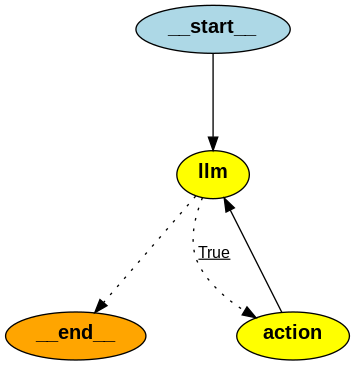

In [ ]:
# Display a visual representation of the agent's workflow graph
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

## Run the Agent (1)

In [ ]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_PvPN1v7bHUxOdyn4J2xJhYOX'}
Back to the model!


In [ ]:
result

{'messages': [HumanMessage(content='What is the weather in sf?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PvPN1v7bHUxOdyn4J2xJhYOX', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174, 'prompt_tokens_details': {'cached_tokens': 0, 'audio_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0, 'audio_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-dbf862b1-44fc-4e9a-9a5e-57a1ad173566-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_PvPN1v7bHUxOdyn4J2xJhYOX'}]),
  ToolMessage(content="[{'url': 'https://www.easeweather.com/north-america/united-states/california/c

In [ ]:
result['messages'][-1].content

'The weather in San Francisco is currently cooler than usual with temperatures averaging 15.6 °F, which is -4.1 °F below the typical seasonal average. The forecast suggests a temperature of 18.5 °F in the next days. The average temperature in San Francisco at the beginning of October is 21.7 °F, and it tends to cool down as the month progresses. Today, it is expected to be sunny with a temperature of 18° / 11°.'

In [ ]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_3AAaDSfchif60Drx9QyyOiZS'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_Ldw8ZaATItg9oW0SRBlhKtpc'}
Back to the model!


In [ ]:
result['messages'][-1].content

'The weather in San Francisco is cooler than usual for October, with temperatures averaging 15.6 °C (60.08 °F) which is -4.1 °C (39.38 °F) below the typical seasonal average. The forecast suggests a temperature of 18.5 °C (65.3 °F) in the coming days.\n\nIn Los Angeles, the weather has been significantly cooler than historical averages by -6.3 °F, with an average temperature of 21.6 °C (70.88 °F) in October. The forecast predicts a temperature of 22.5 °C (72.5 °F) in the next days.\n\nIf you need more detailed information, feel free to ask!'

## Run the Agent (2)

In [ ]:
# Note, the query was modified to produce more consistent results.
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question."
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o") # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': '2024 Super Bowl winner'}, 'id': 'call_HBUU1Lo9WSgKCPKYCAStSb7g'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_ad0GcNKrehRC1dFELPpkpJDM'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of Missouri 2024'}, 'id': 'call_aWcht3PxObZBs0HsgIqC0xVO'}
Back to the model!


In [ ]:
print(result['messages'][-1].content)

1. The Kansas City Chiefs won the Super Bowl in 2024. 

2. The Kansas City Chiefs are headquartered in Kansas City, Missouri.

3. The GDP of Missouri in 2024 was approximately $356.7 billion.
